<a href="https://colab.research.google.com/github/SiluniKeerthiratne/DSGP/blob/siluni/inceptionv3_(_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train #1
*   Trained on 1611 images (2/5 apple,banna)
*   Accuracy 0.98




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
path = "/content/drive/MyDrive/DSGPDevelopment/dataset"

img_size =  (224,224,3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 3



In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd



# Define paths


# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get list of directories in train_path
classes = [cls for cls in os.listdir(path) if os.path.isdir(os.path.join(path, cls))]

train_data = []
for cls in classes:
    cls_path = os.path.join(path, cls)
    imgs = [os.path.join(cls_path, img) for img in os.listdir(cls_path)]
    train_data.extend([(img, cls) for img in imgs])

train_files, test_files = train_test_split(train_data, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)


# Convert file paths and labels to DataFrame
train_df = pd.DataFrame(train_files, columns=['filename', 'class'])
val_df = pd.DataFrame(val_files, columns=['filename', 'class'])
test_df = pd.DataFrame(test_files, columns=['filename', 'class'])

# Create generators
BATCH_SIZE = 32
train_dataset = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
)

validation_dataset = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
)

test_dataset = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
    )




Found 9605 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 1068 validated image filenames belonging to 2 classes.
Found 2669 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
301/301 [==============================] - 1080s 4s/step - loss: 0.3526 - accuracy: 0.8488 - val_loss: 0.2431 - val_accuracy: 0.9148
Epoch 2/15
301/301 [==============================] - 252s 838ms/step - loss: 0.2478 - accuracy: 0.9057 - val_loss: 0.1977 - val_accuracy: 0.9260
Epoch 3/15
301/301 [==============================] - 266s 883ms/step - loss: 0.2155 - accuracy: 0.9184 - val_loss: 0.1770 - val_accuracy: 0.9298
Epoch 4/15
301/301 [==============================] - 264s 877ms/step - loss: 0.1894 - accuracy: 0.9283 - val_loss: 0.1665 - val_accuracy: 0.9373
Epoch 5/15
301/301 [==============================] - 242s 804ms/step - loss: 0.1767 - accuracy: 0.9340 - val_loss: 0.1451 - val_accuracy: 0.9513
Epoch 6/15
301/301 [==============================] - 259s 862ms/step - loss: 0.1602 - accuracy: 0.9412 - val_loss: 0.1380 - val_accuracy: 0.9551
Epoch 7/15
301/301 [==============================] - 243s 806ms/step - loss: 0.1585 - accuracy: 0.9413 - val_loss: 0.1452 - v

In [ ]:
# history2=model.fit(train_dataset,
#                   epochs=20,
#                   validation_data=validation_dataset)

In [ ]:
score = model.evaluate(test_dataset)
print("Accuracy: ",score[1])

84/84 [==============================] - 407s 5s/step - loss: 0.0999 - accuracy: 0.9659
Accuracy:  0.9659048318862915


In [ ]:
from sklearn.metrics import classification_report
test_labels = test_dataset.classes
predictions = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_dataset.class_indices))

84/84 [==============================] - 62s 714ms/step
              precision    recall  f1-score   support

       Fresh       0.43      0.43      0.43      1179
      Rotten       0.55      0.55      0.55      1490

    accuracy                           0.50      2669
   macro avg       0.49      0.49      0.49      2669
weighted avg       0.50      0.50      0.50      2669



In [ ]:
score = model.evaluate(test_dataset)
print("Accuracy: ",score[1])

84/84 [==============================] - 60s 711ms/step - loss: 0.1006 - accuracy: 0.9633
Accuracy:  0.9632821083068848


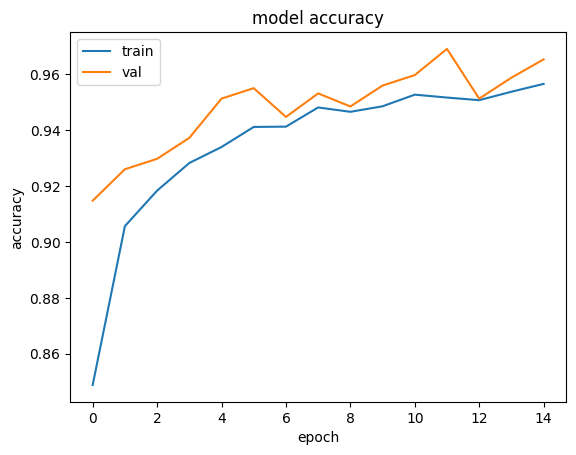

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

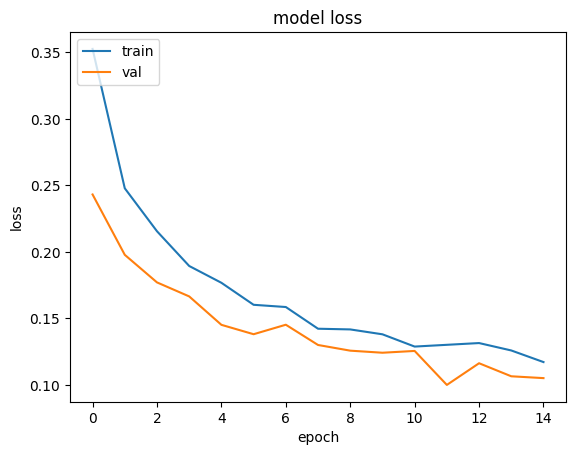

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('model2.pk1','wb'))